### General steps to prepare data for xspec
    1) get complete_df with flags removed
    2) shift tus array in dataframe by tshift provided by cross_corrolate(). NOTE: ADDED to tus_ASIM
    3) use keV_bin() for binning of the energies
    4) change format of dataframe with this command: pd.set_option('display.float_format', '{:.6E}'.format)
    5) export to txt file with command: np.savetxt(r'/Users/andreas/phys/master/GRB/spectral_analysis/GRB190206A_keV_histogram.txt"',df_keV.values, delimiter=',', header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')



# imports

In [334]:
#%run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb #MAC
%run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb #UiB
pd.set_option('display.float_format', '{:.6E}'.format)

all UiB paths loaded
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
safety_time.ipynb loaded successfully!
LC_calibration loaded successfully!


## ASIM

Creating df for short GRB
Absolute time correction subtracted from T0
30 valleys removed
erg converted to keV
df sorted by adr and tus
safety time events flagged. Found 36 flags
Removed 36 flags from df
df sorted by tus
2020-05-21 12:16:39.818925
first tus:  -147481.25 | max tus:  1861131.4722222222
7488
tus array OK ...


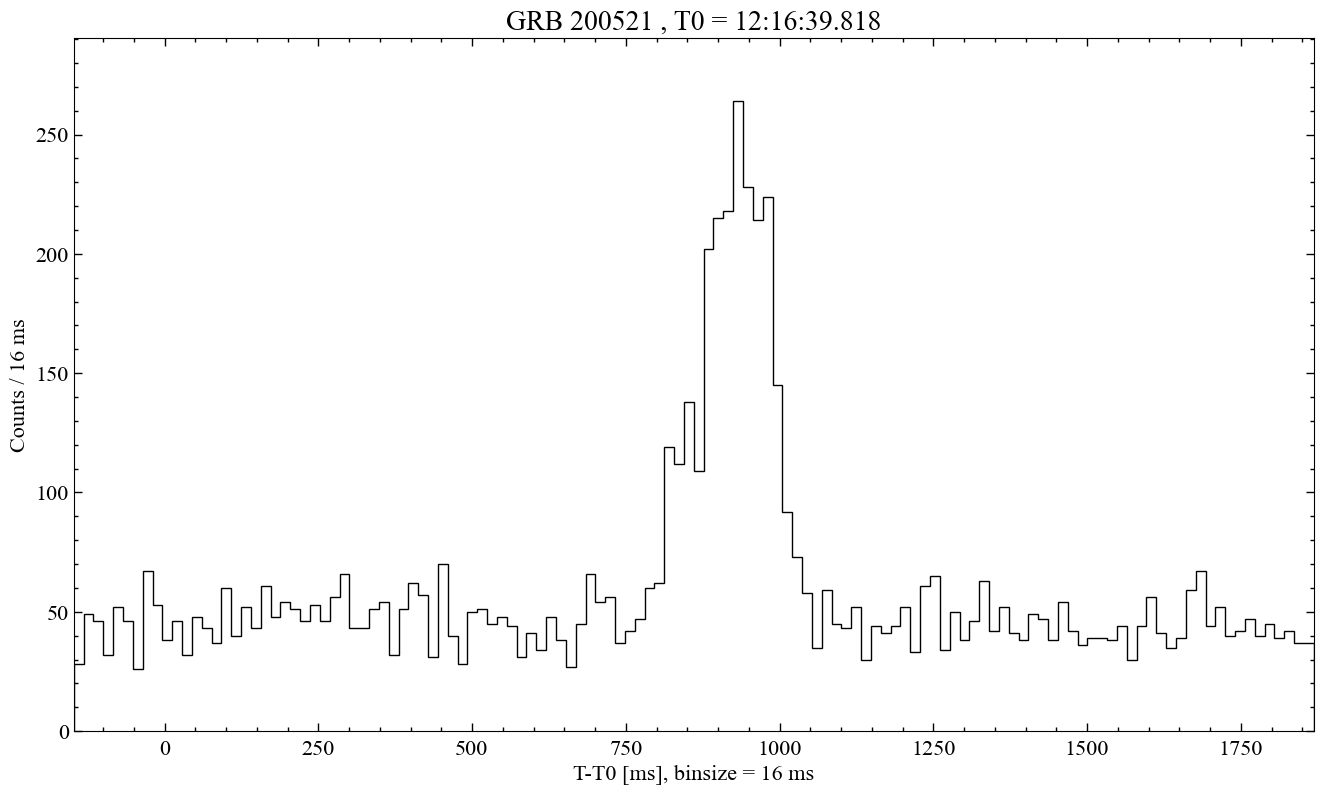

In [3]:
ASIM_df, T0_ASIM = complete_df(grb_id="GRB200521",remove_flag=True)
tus = ASIM_df["tus"].to_numpy(dtype=np.float64)
print(T0_ASIM)
print("first tus: ",min(tus),"| max tus: ", max(tus))
print(len(tus))
plot_HED(tus_arr=tus,T0=T0_ASIM,binsize=16)

## KW

1.008


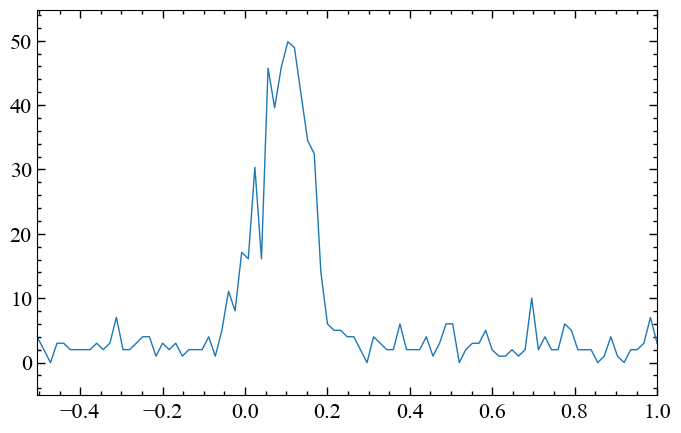

In [45]:
kw_filename = "GRB200521A_16ms.txt"
kw_file = kw_lc_path + kw_filename
binsize=0.016
kw_df = pd.read_csv(kw_file,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float16), kw_df["Tf"].to_numpy(dtype=np.float16),kw_df["G1"].to_numpy(dtype=np.float16), kw_df["G2"].to_numpy(dtype=np.float16), kw_df["G3"].to_numpy(dtype=np.float16)

kw_dt = np.round(np.diff(kw_bin_lo),3)
i_stop_kw = np.where(kw_dt>binsize)[0][0]
print(kw_bin_lo[i_stop_kw])

kw_bin_lo, kw_bin_hi, G1, G2, G3 = kw_bin_lo[:i_stop_kw], kw_bin_hi[:i_stop_kw], G1[:i_stop_kw],G2[:i_stop_kw], G3[:i_stop_kw]
kwCounts = G3
kw_lc = LC(time=kw_bin_lo + binsize/2, counts=kwCounts, skip_checks=True,dt=binsize)
kw_lc.plot()

# CrossCorr
    TODO:
        -Make a function for finding the optimal tlagg
        -run the laggs array containing all of the possible tlaggs.
        -Time range (+- 200 ms) selected from peak count rate pr bin

### tlagg

In [330]:
kevArr = ASIM_df["keV"].to_numpy(dtype=np.float32)
tus = ASIM_df["tus"].to_numpy(dtype=np.float64)/1e6 #converting to seconds
indexInBound = []
for i,kev in enumerate(kevArr):
    if 350<=kev<=1500:
        indexInBound.append(i)
kevArr = kevArr[indexInBound]
tus = tus[indexInBound]

#lagApprox = 0    
#tus += laggApprox
binsize= 0.016
asim_binsOrg = np.round(np.arange(-2,2,0.016,dtype=np.float32),3)

hist = np.histogram(tus,bins=asim_binsOrg)
asimCounts,asimEdges = hist[0],hist[1]
asimLC = LC(time=np.round(asimEdges[:-1],3)+binsize/2, counts=asimCounts, skip_checks=True,dt=binsize)

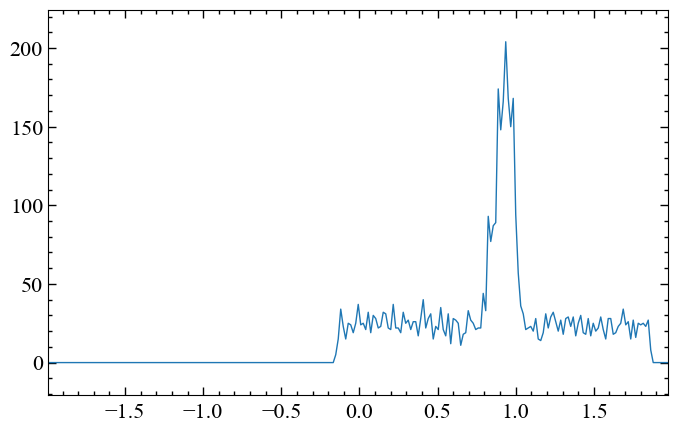

In [331]:
asimLC.plot()

In [335]:
kwCompare,asimCompare = CompareLC(kw_lc=kw_lc,asim_lc=asimLC,binsize=binsize)
#CompareLC actually cuts correctly kw if asim LC is "short"
CC = CrossCorrelation(kwCompare,asimCompare,mode="full")
CClagg=CC.time_shift
tlagg = CClagg
print("Total lagg (s): ", tlagg, "| CC lagg: ", CClagg)
kwFinal,asimFinal = CompareLC(kw_lc=kw_lc,asim_lc=asimLC.shift(tlagg),binsize=binsize,okReturn=True)

Total lagg (s):  -0.8331298828125 | CC lagg:  -0.8331298828125


/Home/siv30/wad005/anaconda3/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


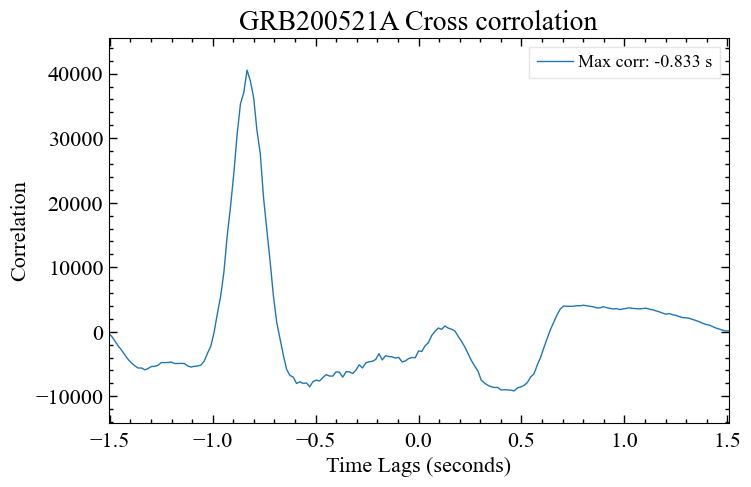

In [341]:
plt.plot(CC.time_lags,CC.corr,label="Max corr: -0.833 s")
plt.title("GRB200521A Cross corrolation")
plt.xlabel('Time Lags (seconds)')
plt.ylabel('Correlation')
plt.legend()
#plt.savefig("/Home/siv30/wad005/master/GRB/pyplots/CrossCorrolation/GRB200521A/CC_asim_kw.png")
plt.show()

### comparing LC's

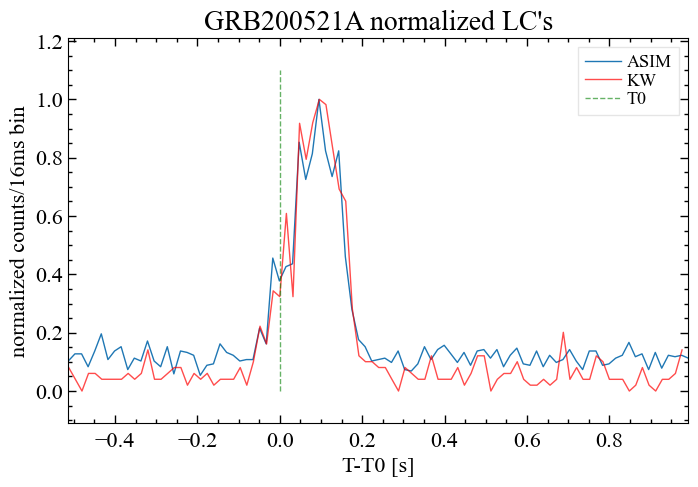

In [340]:
i_asimStart = find_nearest(asimFinal.bin_lo,kwCompare.bin_lo[0])
i_kwEnd = find_nearest(kwCompare.bin_lo,asimFinal.bin_lo[-1])

plt.plot(np.round(asimFinal.bin_lo[i_asimStart:],3),asimFinal.counts[i_asimStart:]/max(asimFinal.counts),label="ASIM")
plt.plot(np.round(kwCompare.bin_lo[:i_kwEnd],3),kwCompare.counts[:i_kwEnd]/max(kwCompare.counts),c="r",alpha=0.7,label="KW")

plt.title("GRB200521A normalized LC's")
plt.xlabel("T-T0 [s]")
plt.ylabel("normalized counts/16ms bin")
plt.vlines(x=0.0,ymin=0,ymax=1.1,color="g",label="T0",alpha=0.6,linestyle="--")
plt.legend()
#plt.savefig("/Home/siv30/wad005/master/GRB/pyplots/CrossCorrolation/GRB200521A/overlappingLC_asim_kw.png")
plt.show()


# Extracting ASIM data

In [342]:
ASIM_df,T0 = complete_df(grb_id="GRB200521",remove_flag=True)
T0_shift = T0 + timedelta(seconds=tlagg)
ASIM_df["tus"] = ASIM_df["tus"].to_numpy()+tlagg*1e6

Creating df for short GRB
Absolute time correction subtracted from T0
30 valleys removed
erg converted to keV
df sorted by adr and tus
safety time events flagged. Found 36 flags
Removed 36 flags from df
df sorted by tus


tus array OK ...


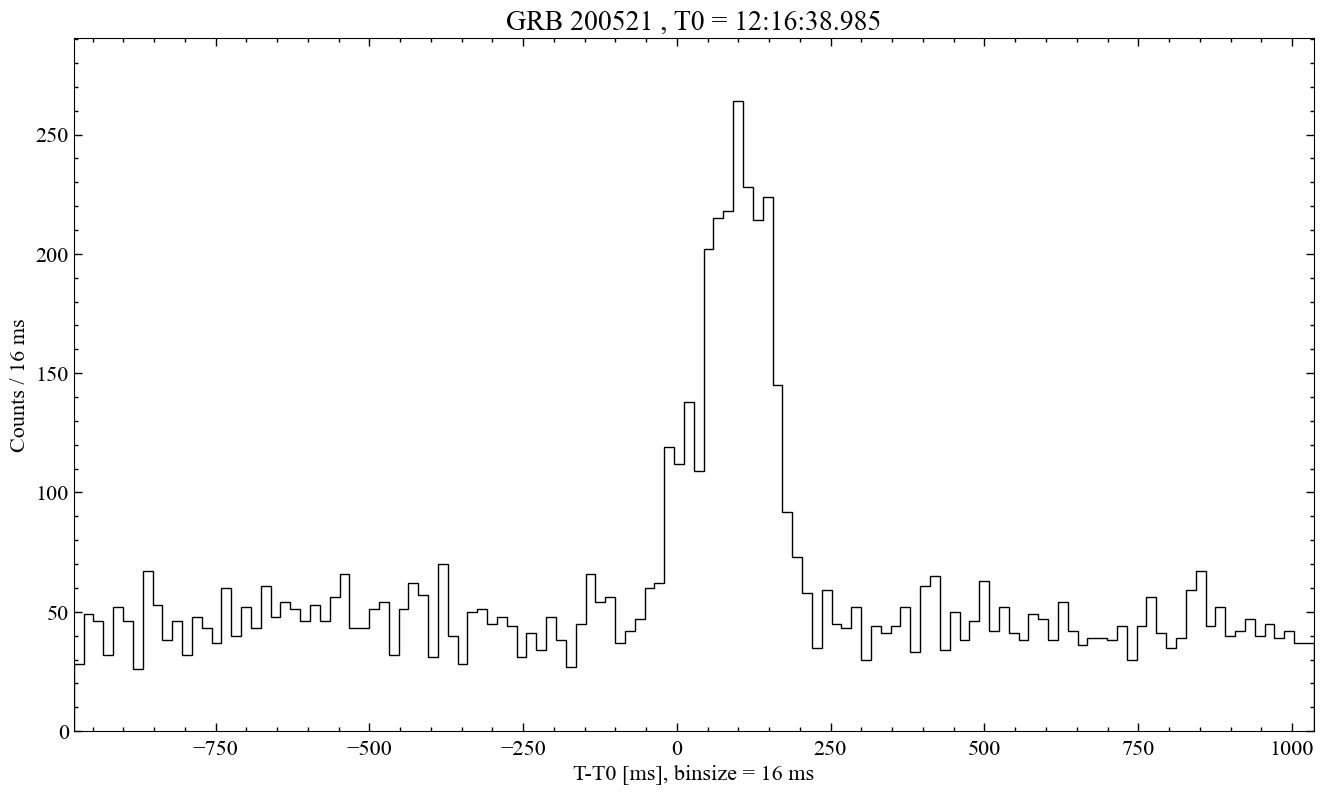

In [343]:
plot_HED(tus_arr=ASIM_df["tus"].to_numpy(),T0=T0_shift,binsize=16)

In [ ]:
keV_df = keV_hist(df=ASIM_df,time_interval=(0,0.064),
                 keV_interval="max",
                 duration=0.064,
                 )
keV_df
#All triggers in the time_interval are kept

In [ ]:
#np.savetxt(r'/Home/siv30/wad005/master/GRB/xspec/GRB201227A/ASIM201227.txt',keV_df.values, delimiter=',', header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')

In [346]:
0.9-0.3

0.6000000000000001

### bakground extraction 

keV_bg = keV_hist(df=ASIM_df,time_interval=(-0.9,-0.3),
                 keV_interval="max",
                 duration=0.6,
                 )

In [14]:
#np.savetxt(r'/Home/siv30/wad005/master/GRB/xspec/GRB201227A/ASIM201227_bg.txt',keV_bg.values, delimiter=',', header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')